In [64]:
!pip install sacrebleu
!pip install rouge-score

In [ ]:
import os
import json
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

checkpoint = "bigcode/tiny_starcoder_py"
device = "cuda"

tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForCausalLM.from_pretrained(checkpoint).to(device)

if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id

input_file = '/content/drive/My Drive/data/dataset.json'
output_file = '/content/drive/My Drive/data/dataset_with_predictions.json'

with open(input_file, 'r', encoding='utf-8') as file:
    data = json.load(file)

for sample in data:
    input_text = f"<fim_prefix>{sample['prefix']}<fim_suffix>{sample['suffix']}<fim_middle>"
    inputs = tokenizer(input_text, return_tensors="pt").to(device)

    attention_mask = inputs["input_ids"] != tokenizer.pad_token_id
    outputs = model.generate(
        inputs["input_ids"],
        attention_mask=attention_mask,
        max_new_tokens=20,
        pad_token_id=tokenizer.pad_token_id
    )
    prediction = tokenizer.decode(outputs[0], skip_special_tokens=False)

    start = prediction.find("<fim_middle>") + len("<fim_middle>")
    end = prediction.find("<|endoftext|>") if "<|endoftext|>" in prediction else len(prediction)
    middle_text = prediction[start:end].strip()
    sample["prediction"] = middle_text

with open(output_file, 'w', encoding='utf-8') as file:
    json.dump(data, file, indent=4, ensure_ascii=False)

print(f"Dataset with predictions saved to '{output_file}'")


In [65]:
from sacrebleu.metrics import CHRF, BLEU
from rouge_score import rouge_scorer

def modified_exact_match(pred, ref):
    return int(pred[:len(ref)].strip() == ref.strip())

def exact_match(pred, ref):
    return int(pred.strip() == ref.strip())

input_file = '/content/drive/My Drive/data/dataset_with_predictions.json'
output_file = '/content/drive/My Drive/data/dataset_with_predictions_eval.json'

with open(input_file, 'r', encoding='utf-8') as file:
    data = json.load(file)

chrf_metric = CHRF()
bleu_metric = BLEU(effective_order=True)
rouge_scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

for sample in data:
    middle_text = sample["prediction"]
    reference = sample["middle"]

    sample["exact_match"] = exact_match(middle_text, reference)
    sample["modified_exact_match"] = modified_exact_match(middle_text, reference)
    sample["chrf"] = round(chrf_metric.sentence_score(middle_text, [reference]).score, 2)
    sample["bleu"] = round(bleu_metric.sentence_score(middle_text, [reference]).score, 2)
    sample["rougeL"] = round(rouge_scorer.score(reference, middle_text)["rougeL"].fmeasure, 2)
    sample["manual"] = ""

with open(output_file, 'w', encoding='utf-8') as file:
    json.dump(data, file, indent=4, ensure_ascii=False)

print(f"Dataset with evaluations saved to '{output_file}'")


Dataset with evaluations saved to '/content/drive/My Drive/data/dataset_with_predictions_eval.json'


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import json


input_file = '/content/drive/My Drive/data/dataset_labelled.json'
with open(input_file, 'r', encoding='utf-8') as file:
    data = json.load(file)


df = pd.DataFrame(data)

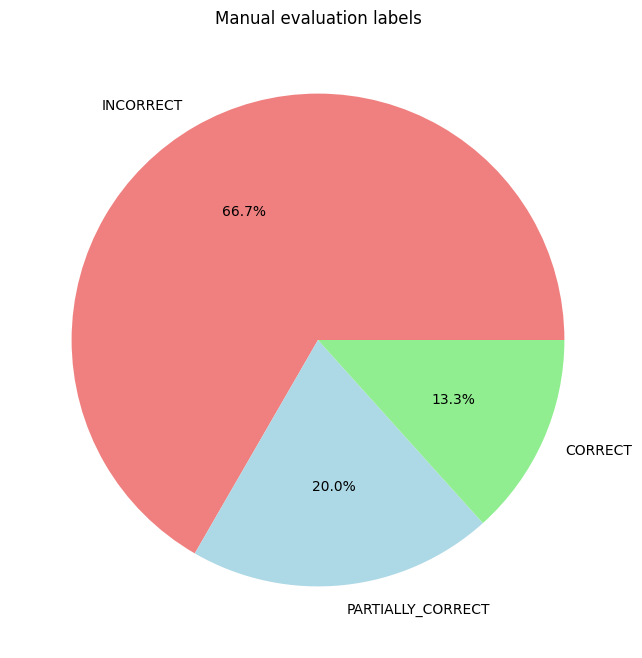

In [7]:
color_map = {
    'CORRECT': 'lightgreen',
    'PARTIALLY_CORRECT': 'lightblue',
    'INCORRECT': 'lightcoral',
    1: 'lightgreen',
    0: 'lightcoral'
}


plt.figure(figsize=(8, 8))
df['manual'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=[color_map[label] for label in df['manual'].value_counts().index])
plt.title('Manual evaluation labels')
plt.ylabel('')
plt.show()



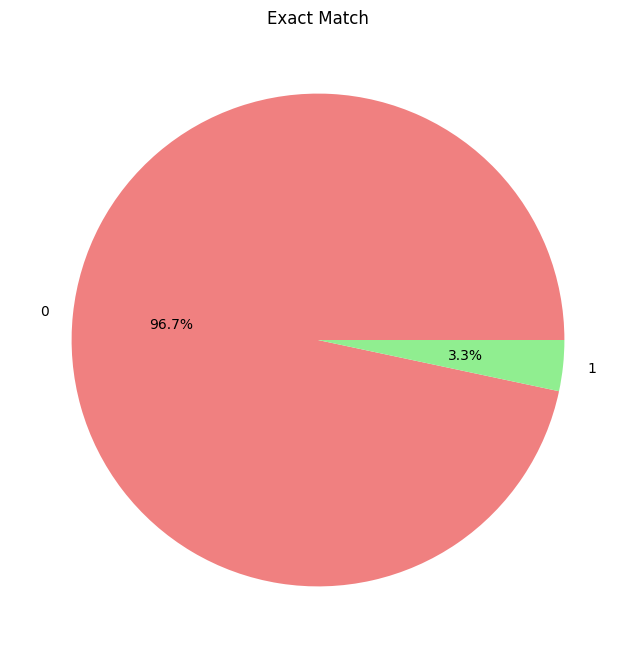

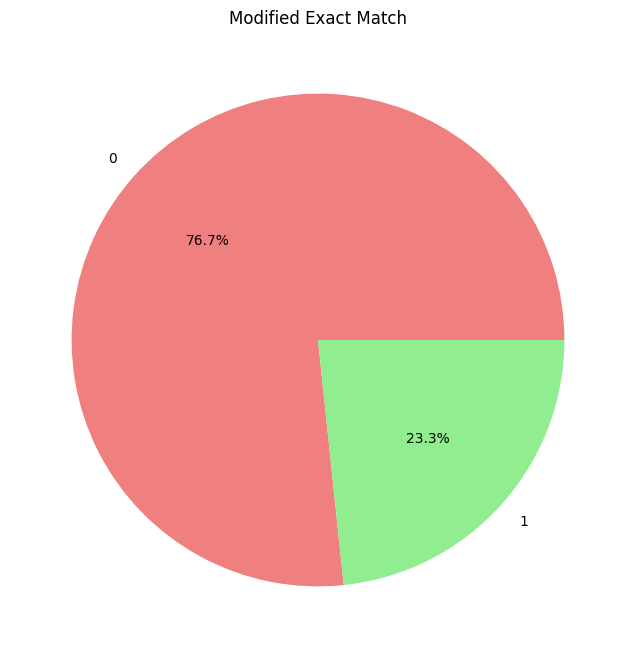

In [8]:
plt.figure(figsize=(8, 8))
df['exact_match'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=[color_map.get(label, 'gray') for label in df['exact_match'].value_counts().index])
plt.title('Exact Match')
plt.ylabel('')
plt.show()

plt.figure(figsize=(8, 8))
df['modified_exact_match'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=[color_map.get(label, 'gray') for label in df['modified_exact_match'].value_counts().index])
plt.title('Modified Exact Match')
plt.ylabel('')
plt.show()

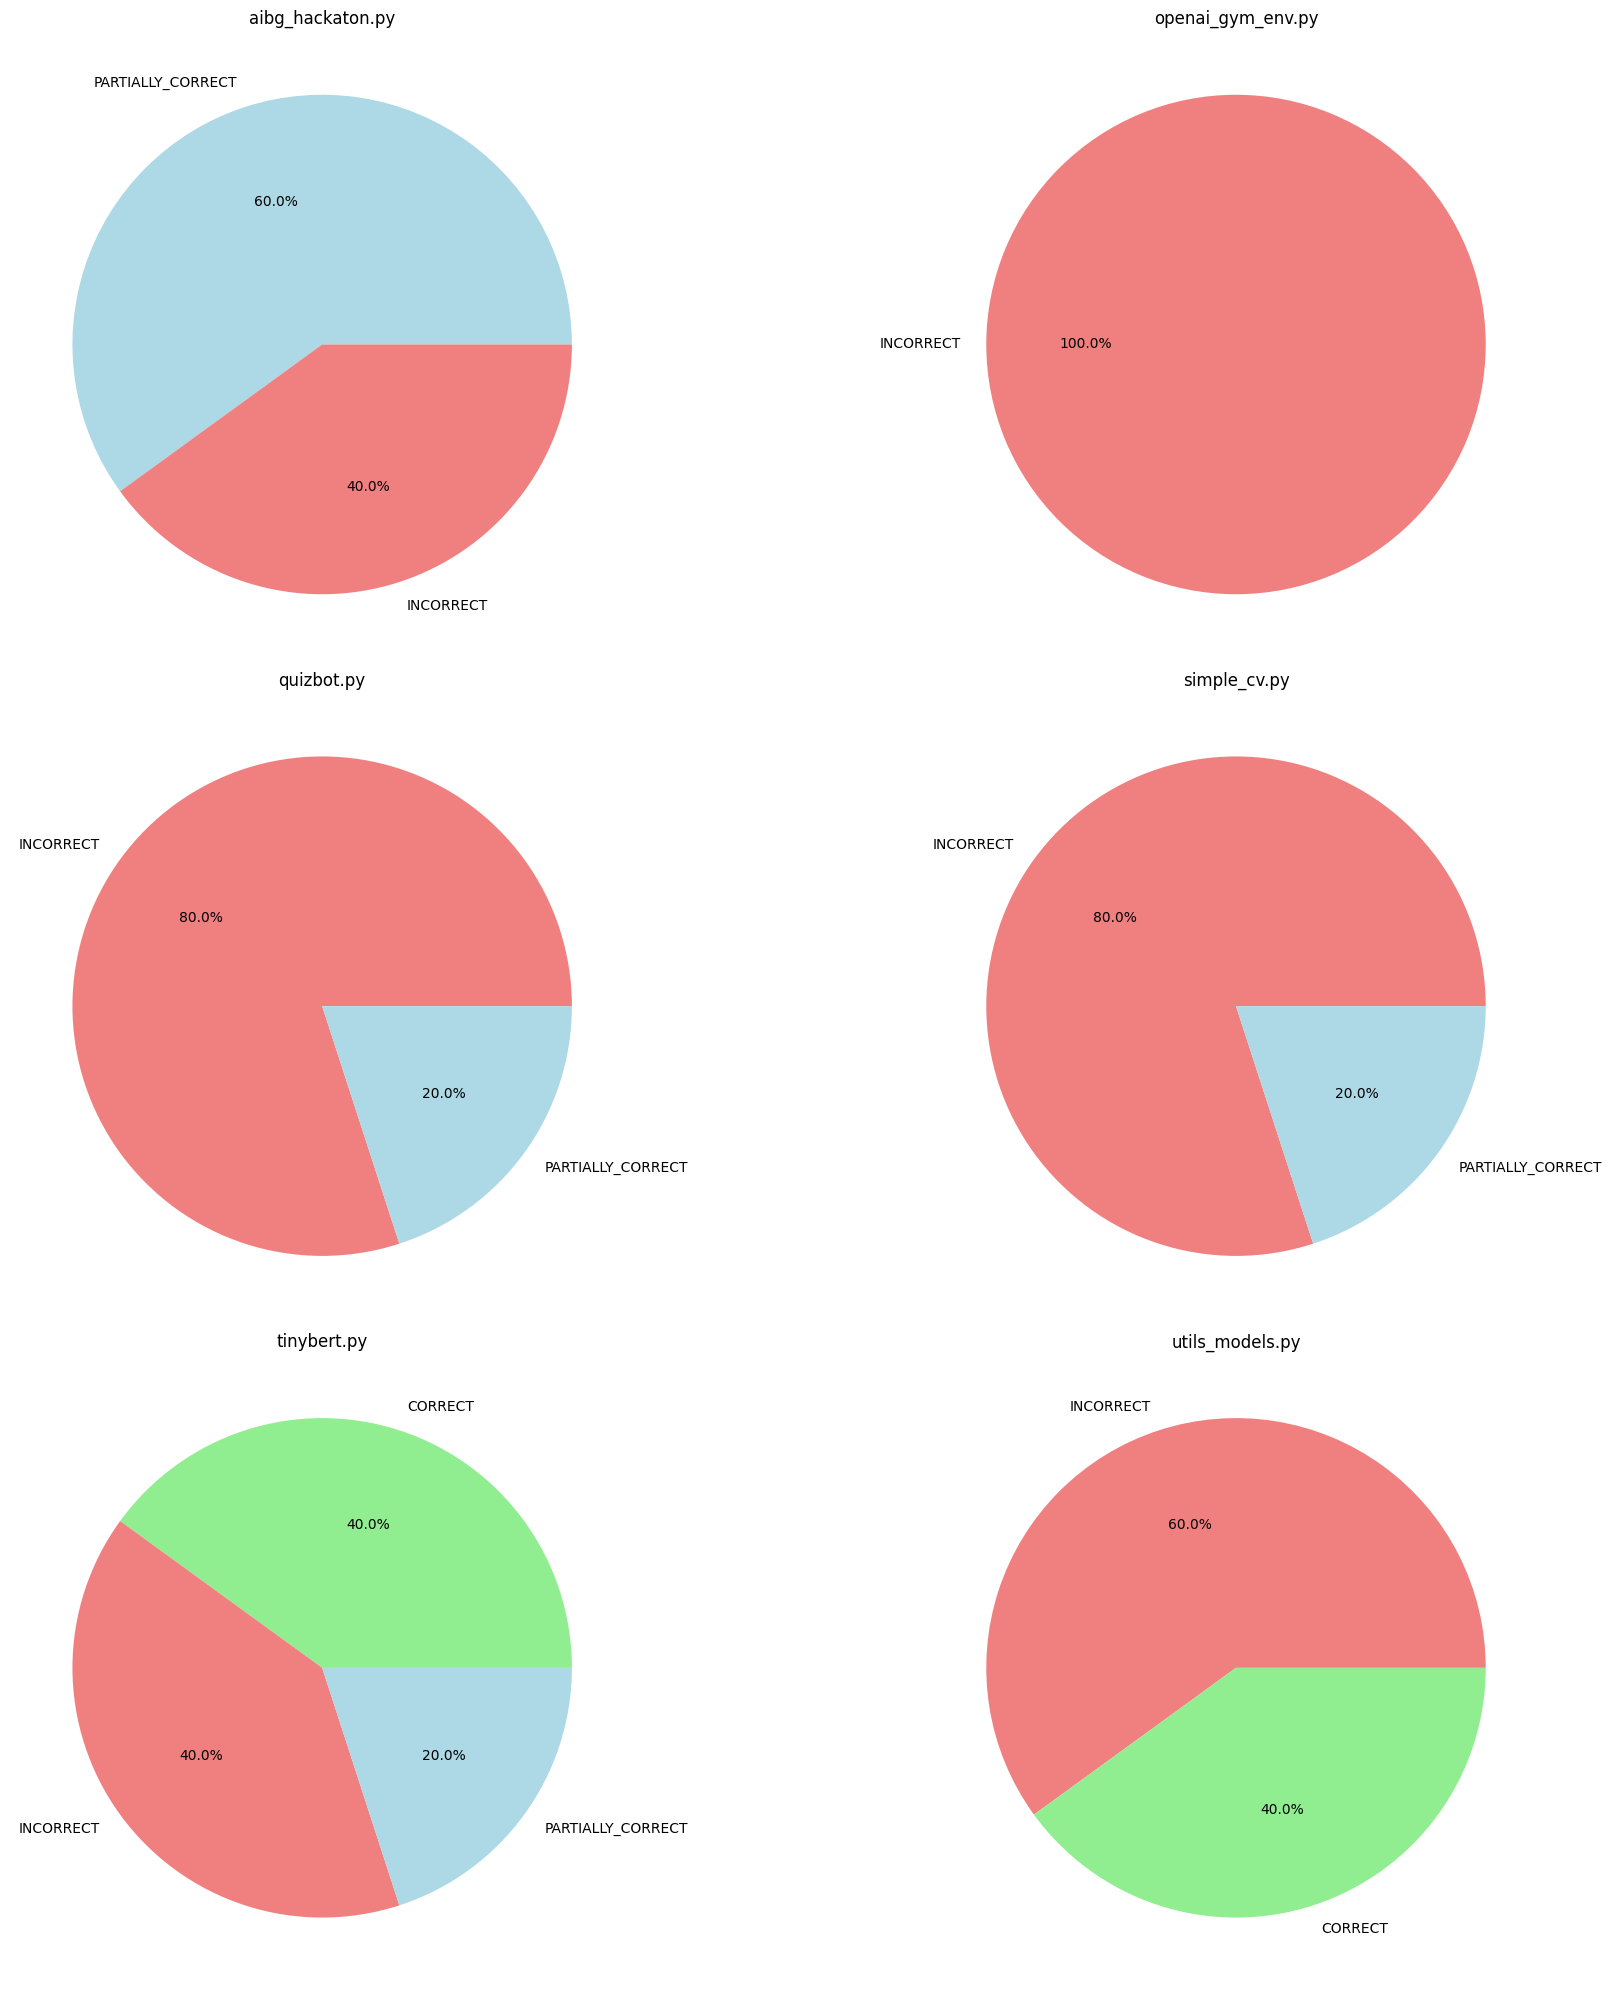

In [69]:
import matplotlib.pyplot as plt

files = df['file'].unique()

plt.figure(figsize=(20, 20))
for i, file in enumerate(files):
    plt.subplot(3, 2, i + 1)
    file_data = df[df['file'] == file]['manual'].value_counts()


    colors = [color_map[label] for label in file_data.index]
    file_data.plot(kind='pie', autopct='%1.1f%%', colors=colors)

    plt.title(f'{file}')
    plt.ylabel('')

plt.tight_layout()
plt.show()


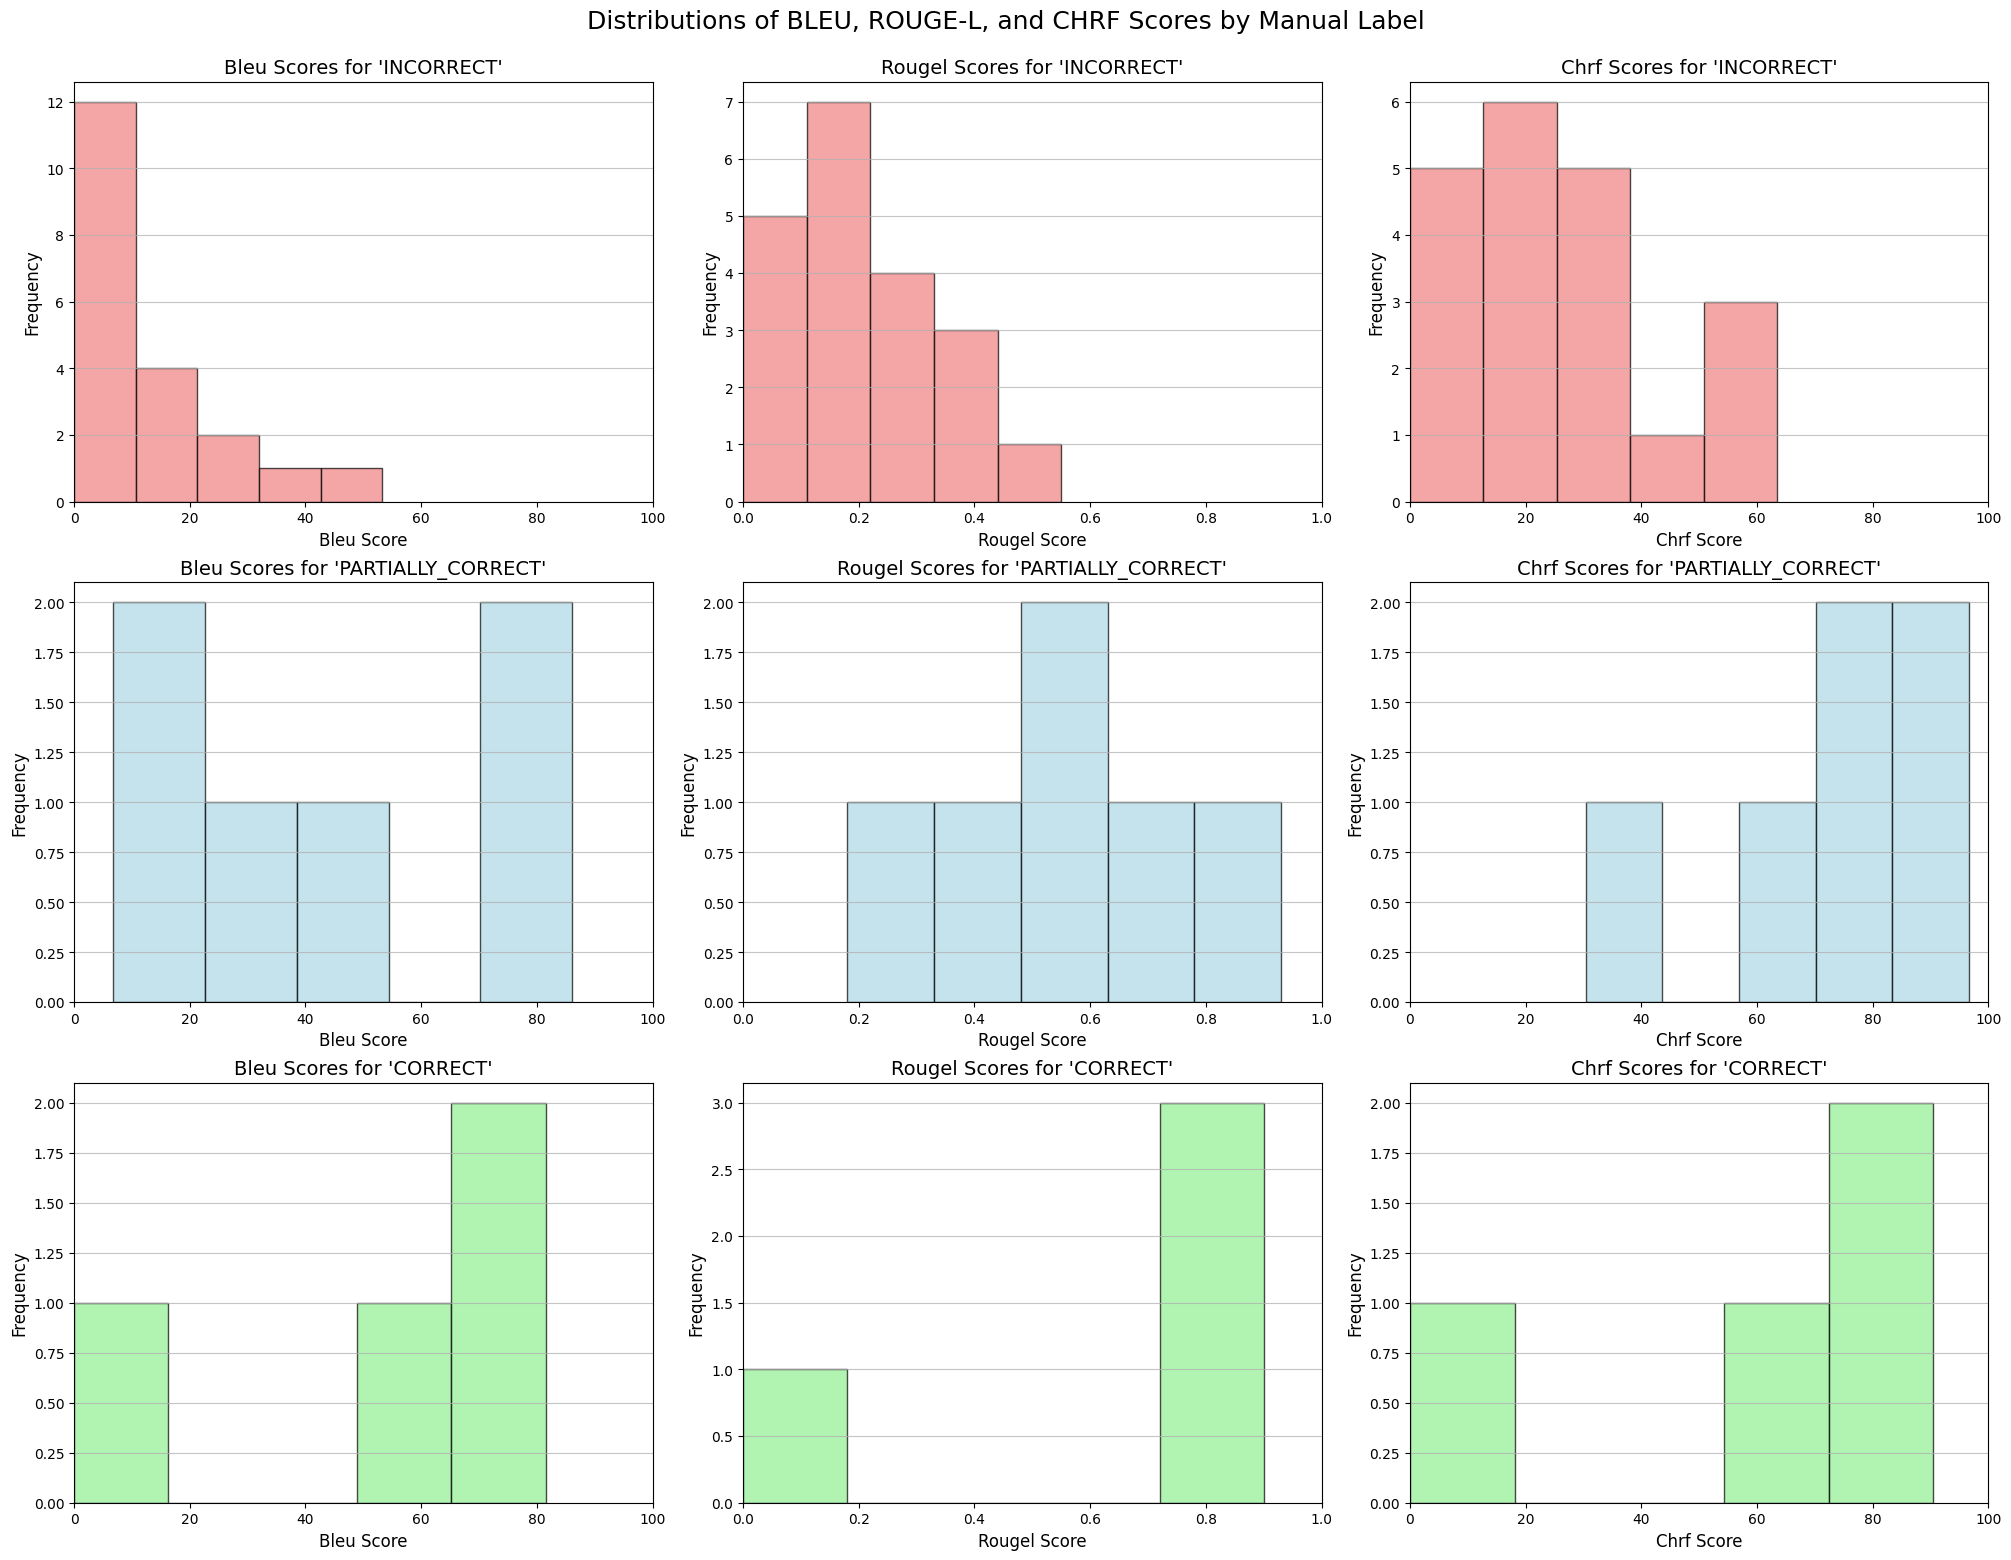

In [70]:
import numpy as np
import matplotlib.pyplot as plt

metrics = ['bleu', 'rougeL', 'chrf']
num_labels = len(df['manual'].unique())
num_metrics = len(metrics)

fig, axes = plt.subplots(num_labels, num_metrics, figsize=(20, 5 * num_labels), constrained_layout=True)


if num_labels == 1:
    axes = np.array([axes])


metric_ranges = {
    'bleu': (0, 100),
    'rougeL': (0, 1),
    'chrf': (0, 100)
}

for i, label in enumerate(df['manual'].unique()):
    subset = df[df['manual'] == label]
    for j, metric in enumerate(metrics):
        ax = axes[i, j]
        ax.hist(
            subset[metric],
            bins=5,
            edgecolor='black',
            alpha=0.7,
            color=color_map.get(label, 'gray')
        )
        ax.set_title(f"{metric.capitalize()} Scores for '{label}'", fontsize=14)
        ax.set_xlabel(f"{metric.capitalize()} Score", fontsize=12)
        ax.set_ylabel("Frequency", fontsize=12)
        ax.grid(axis='y', alpha=0.75)
        ax.set_xlim(metric_ranges.get(metric, (0, 100)))

plt.suptitle("Distributions of BLEU, ROUGE-L, and CHRF Scores by Manual Label", fontsize=18, y=1.03)
plt.show()


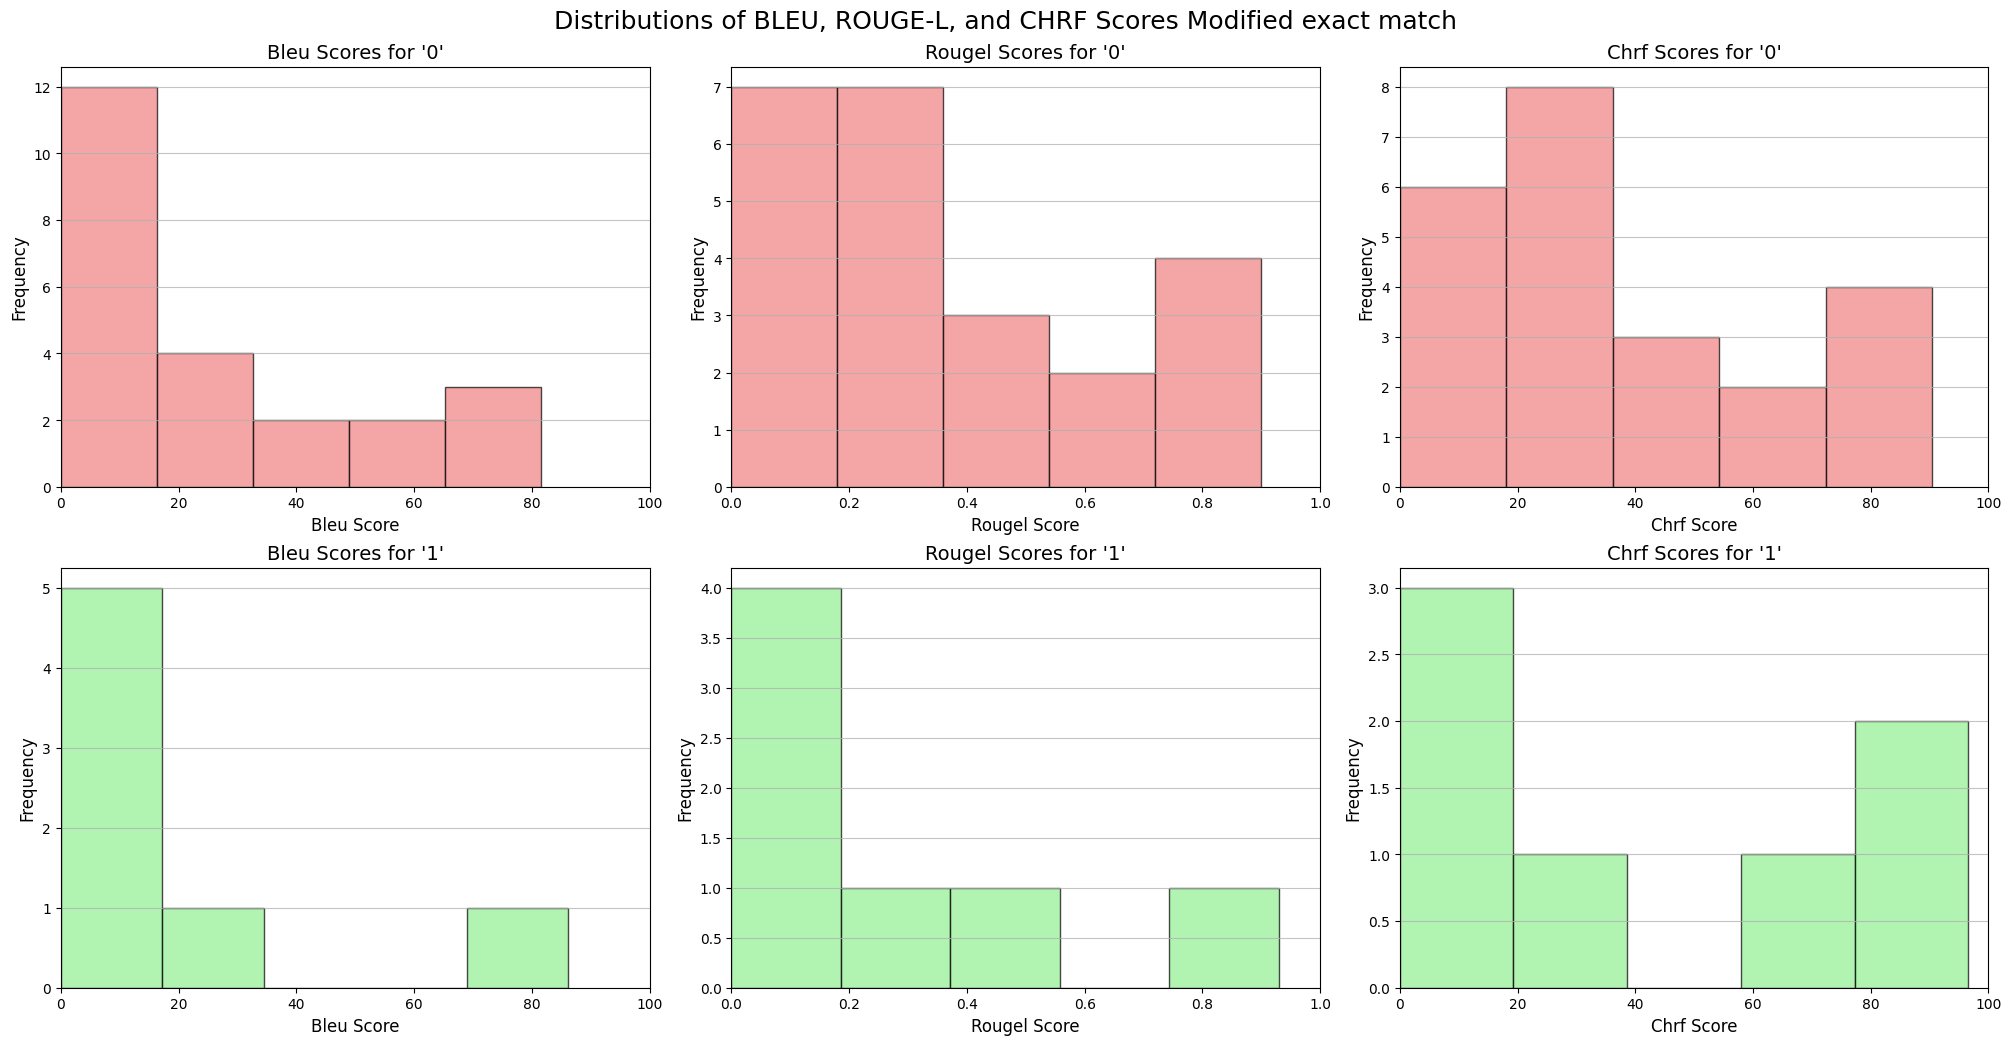

In [6]:
import numpy as np
import matplotlib.pyplot as plt

metrics = ['bleu', 'rougeL', 'chrf']
num_labels = len(df['modified_exact_match'].unique())
num_metrics = len(metrics)

fig, axes = plt.subplots(num_labels, num_metrics, figsize=(20, 5 * num_labels), constrained_layout=True)


if num_labels == 1:
    axes = np.array([axes])


metric_ranges = {
    'bleu': (0, 100),
    'rougeL': (0, 1),
    'chrf': (0, 100)
}

for i, label in enumerate(df['modified_exact_match'].unique()):
    subset = df[df['modified_exact_match'] == label]
    for j, metric in enumerate(metrics):
        ax = axes[i, j]
        ax.hist(
            subset[metric],
            bins=5,
            edgecolor='black',
            alpha=0.7,
            color=color_map.get(label, 'gray')
        )
        ax.set_title(f"{metric.capitalize()} Scores for '{label}'", fontsize=14)
        ax.set_xlabel(f"{metric.capitalize()} Score", fontsize=12)
        ax.set_ylabel("Frequency", fontsize=12)
        ax.grid(axis='y', alpha=0.75)
        ax.set_xlim(metric_ranges.get(metric, (0, 100)))

plt.suptitle("Distributions of BLEU, ROUGE-L, and CHRF Scores Modified exact match", fontsize=18, y=1.03)
plt.show()
